Still to do :
- Matching the beer between both datasets to get enough ratings for each beer (only treating BeerAdvocate in the second part of this preliminary analysis)
- Keep diving into WHAT makes a beer controversial (such as the attribute)
- Try to aggregate somehow the attribute and see WHICH beers are controversial (maybe by style or abv or...)
- ...


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import numpy as np


In [2]:
# Later we will important the cleaned dataset
# BA for Beer Advocate datasets
# RB for Rate Beer datasets
# need to convert the review and rating txt as csv

# Importation of dataset
beers_BA_df = pd.read_csv('../Dataset/BeerAdvocate/beers.csv')
beers_RB_df = pd.read_csv('../Dataset/RateBeer/beers.csv')
users_BA_df = pd.read_csv('../Dataset/BeerAdvocate/users.csv')
users_RB_df = pd.read_csv('../Dataset/RateBeer/users.csv')




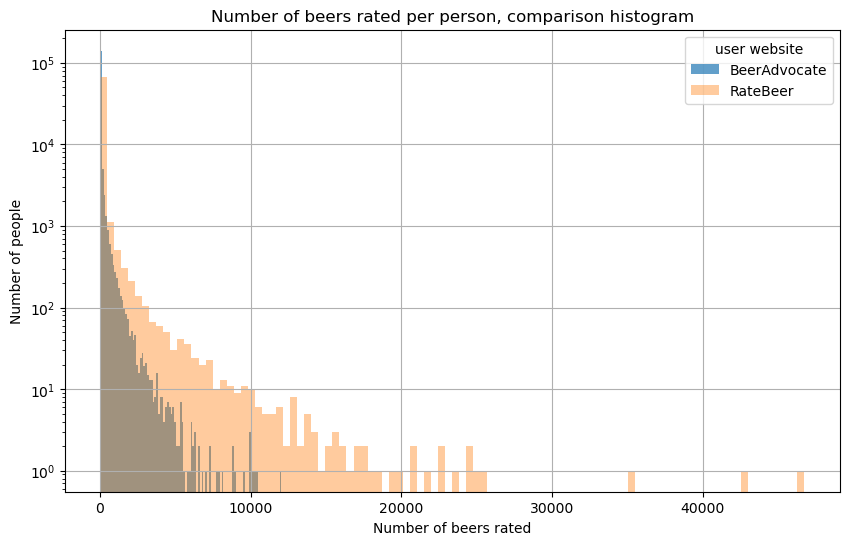

In [3]:
# Plotting number of ratings made per user in an histogram
plt.figure(figsize=(10, 6))

users_BA_df['nbr_ratings'].hist(bins=100, log=True, alpha=0.7, label='BeerAdvocate')
users_RB_df['nbr_ratings'].hist(bins=100,log=True, alpha=0.4, label='RateBeer')

plt.xlabel("Number of beers rated")
plt.ylabel("Number of people")
plt.legend(title='user website')
plt.title('Number of beers rated per person, comparison histogram')
plt.show()

RateBeer has only about 20-30 users with more than 12'000 ratings
BeerAdvocate has only abouth 20-30 users above 5'000

Now is time to define class on users related to how many ratings they did.
- Novice are users with only a few ratings, let's say 1-20.
- Enthusiasts are users with moderate number of ratings, let's say 21-100
- Connoisseur are users with high number of ratings, let's say 101+

It is important to note that this choice is arbitrary. It could me made differently or could be interactive for the reader of the story to label the users differently according to how many ratings he thinks is enough to be a connoisseur/enthusiasts/novice.

Another important things to take into account is that these classes do not represent users as novice or connoisseur about **beers**, but about **rating** on this particular website.

Let's classify now the users in the three mentioned categories.



In [4]:
def classify_user_rating_level(user_df, novice_level=20, enthusiasts_level=100):
    
    def __classify(nbr_ratings):
        if nbr_ratings <= novice_level:
            return 'novice'
        elif nbr_ratings <= enthusiasts_level:
            return 'enthusiast'
        else:
            return 'connoisseur'
        
    user_df['rating_user_level'] = user_df['nbr_ratings'].apply(__classify)

    return user_df
    

In [5]:
users_classified_BA = classify_user_rating_level(users_BA_df, novice_level=10)
users_classified_RB = classify_user_rating_level(users_RB_df, novice_level=10)
print("Number of people per class BA dataset", users_classified_BA['rating_user_level'].value_counts())
print("Number of people per class RB dataset", users_classified_RB['rating_user_level'].value_counts())

Number of people per class BA dataset rating_user_level
novice         107300
enthusiast      32017
connoisseur     14387
Name: count, dtype: int64
Number of people per class RB dataset rating_user_level
novice         53361
enthusiast     10423
connoisseur     6390
Name: count, dtype: int64


As we can see, if we want to do further analysis using the three classes of users, we will need to either rebalance the datasets, weight the analysis, or...

Furthermore, we could try to aggregate people who rated on both sites ?

In [6]:
users_classified_RB.sample(3)


,nbr_ratings,user_id,user_name,joined,location,rating_user_level
68874,1,457370,montecarlo,1.491386e+09,Belgium,novice
31716,2,325543,JapanCarl,1.404900e+09,Japan,novice
58977,8,285526,HopYoda,1.382609e+09,NaN,novice


We can keep this for further analysis. Let's pass to naive first analysis of the controversiality of attributes

Let's try now to get a glimpse of the controversiality of a beer by looking at each attribute of beers and their ratings values.

In [7]:
# Importing ratings in csv (8 minutes)
ratings_RB_df = pd.read_csv('../Dataset/RateBeer/ratings.csv')
ratings_BA_df = pd.read_csv('../Dataset/BeerAdvocate/ratings.csv')

In [8]:
ratings_RB_df.sample()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
5986887,Gales Prize Old Ale (1920s - 2006),5996,Gales,737,Old Ale,9.0,1035367200,Prostman,2896,5,8,4,9,19,4.5,This beer poured with a nice reddish brown bod...


In [9]:
ratings_BA_df.sample()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
884560,La Trappe Jubilaris,103481,Bierbrouwerij De Koningshoeven B.V.,184,Belgian Dark Ale,6.0,1403258400,patre_tim,patre_tim.670260,NaN,NaN,NaN,NaN,NaN,4.5,NaN,False


In [10]:
# Different interesting attributed of a beer.
# attributed contains rated basic attributes
# extended_attributes contain everything than could be rated by users of the website
# external_attributes contain the attributes of the beer itself, independant of the ratings

attributes = ['appearance', 'aroma', 'palate', 'taste']
extended_attributes = attributes + ['overall', 'rating', 'text']
external_attributes = ['style', 'abv']

In [11]:
# Taking a part of the dataset to try and treat it faster.
# Unused for the moment. May be useless
ratings_BA_df_tmp = ratings_BA_df.iloc[0:math.floor(len(ratings_BA_df)/5)]
print(len(ratings_BA_df))
print(len(ratings_BA_df_tmp))

8393032
1678606


## Part 2
The analysis of controversiality can be done in different manners :
- We compute the variance of each attributes for each beer, then study which attribute seems to be the more controversial by looking at the distribution of the variances 
- We compute the variance across the **overall** rating and classify beers as controversial if above a certain threshold. Then we look which of the 4 attributes influences the most the overall score controversiality
- We count for each beer which attributes is the most controversial

To analyze the controversiality of a beer, we need many ratings. As a result, we must choose a threshold deciding how many ratings are necessary for a beer to be treated in the analysis. This number is arbitrary and could be chosen by the reader.

We choose 10 ratings as a threshold for now.

Let's first try some analysis with the Beer Advocate dataset. This dataset has its four main attributes with a range and resolution of 1 - 5 and 1 respectively.

For this first analysis, we focus on the four main attributes defining a beer :  appearance, aroma, palate, taste.
As a result, we will drop the ratings with no answer for this attributes in this part

### Part 2.1
Let's try the first way of analysing :
- We compute the variance of each attributes for each beer, then study which attribute seems to be the more controversial by looking at the distribution of the variances 


In [26]:
# Filtering beers with enough ratings
low_threshold_nb_ratings = 10
high_threshold_nb_ratings = 50

filtered_beers_BA = beers_BA_df[beers_BA_df['nbr_ratings'] >= low_threshold_nb_ratings] # Could maybe keep only name and ID ? For memory purposes ?
print("Pourcentage of beers remaining : {:.2f} %".format(100 * len(filtered_beers_BA) / len(beers_BA_df)))

# Filtering the ratings on which beers are rated enough
filtered_ratings_BA = ratings_BA_df[ratings_BA_df['beer_id'].isin(filtered_beers_BA['beer_id'])] # 30 seconds
print("Pourcentage of ratings remaining : {:.2f} %".format(100 * len(filtered_ratings_BA) / len(ratings_BA_df)))

# Filtering rows with NA value for one of the attributes
column_to_check = ['appearance', 'aroma', 'palate', 'taste', 'overall'] # Row to drop if any NA in those columns
attributes_ratings_BA = filtered_ratings_BA.dropna(subset=column_to_check, how='any')
print("Pourcentage of ratings remaining : {:.2f} %".format(100 * len(attributes_ratings_BA) / len(ratings_BA_df)))

# Grouping ratings for each beer 
grouped_ratings_BA = attributes_ratings_BA.groupby('beer_id')


Pourcentage of beers remaining : 21.79 %
Pourcentage of ratings remaining : 93.94 %
Pourcentage of ratings remaining : 52.09 %


In [27]:
# Finding the variance for each attribute for each beer
variance_ratings_attributes_BA = grouped_ratings_BA[attributes].var()
variance_ratings_attributes_BA.head(5)

,appearance,aroma,palate,taste
beer_id,,,,
4,0.413889,0.344444,0.566667,0.691667
5,0.295799,0.326182,0.352413,0.372201
6,0.198003,0.278801,0.289798,0.277225
7,0.401458,0.465628,0.431587,0.508657
8,0.367960,0.414098,0.428843,0.486016


In [28]:
variance_ratings_attributes_BA.describe()

,appearance,aroma,palate,taste
count,60231.000000,60231.000000,60231.000000,60231.000000
mean,0.197245,0.215052,0.229368,0.247306
std,0.159013,0.178171,0.185018,0.212878
min,0.000000,0.000000,0.000000,0.000000
25%,0.105865,0.109835,0.116326,0.118519
50%,0.161020,0.172760,0.183333,0.191667
75%,0.241883,0.266476,0.286261,0.307643
max,6.125000,6.125000,6.125000,8.000000


We can observe a maximum variance of 6.125 and 8 for the attributes. This might be strange considering atttributes are ranged between 1 and 5 and we have at least 10 ratings each time.
Let's look at what happened.

In [29]:
print(variance_ratings_attributes_BA[variance_ratings_attributes_BA.taste==8])
grouped_ratings_BA.get_group(86300)

         appearance  aroma  palate  taste
beer_id                                  
86300         6.125    4.5   6.125    8.0


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
7019946,Diablo Rojo Fuego,86300,Boneyard Beer Company,23066,Chile Beer,NaN,1371204000,Rosanne,rosanne.735736,1.0,1.0,1.0,1.0,1.0,1.00,"no aroma, low carbonation, no taste until the ...",True
7019949,Diablo Rojo Fuego,86300,Boneyard Beer Company,23066,Chile Beer,NaN,1350640800,TheBungyo,thebungyo.11234,4.5,4.0,4.5,5.0,5.0,4.68,By far the best chili beer I've ever had. If I...,True


As we can see, only two ratings are retained for this beer. This means an error has occured somewhere. The reason is we dropped the rows containing NAs after considering the minimal number of ratings for a beer to be taken into the analysis.
Let's remedy to this.

CI-DESSUS JAI LAISSE MON ERREUR POUR LE MOMENT AVEC UNE PETITE EXPLICATION POUR BIEN COMPRENDRE MAIS ON POURRA PTTR ENLEVER CA PLUS TARD

In [ ]:
threshold_nb_ratings = 10

# Filter the ratings with NA values for attributes
filtered_ratings_BA = ratings_BA_df.dropna(subset=attributes, how='any') # we don't have to check if overall column is na or not as it is mandatory to answer in the rating of the webist
print("Pourcentage of ratings remaining after dropping rows with NA in attributes: {:.2f} %".format(100 * len(filtered_ratings_BA) / len(ratings_BA_df)))

# Group the beer per id and compute the size of each group (the number of filtered ratings for each beer)
valid_ratings_count = filtered_ratings_BA.groupby('beer_id').size()

# Keep all ratings for which the beer has enough filtered ratings
filtered_beers = valid_ratings_count[valid_ratings_count >=threshold_nb_ratings]
filtered_ratings_BA = filtered_ratings_BA[filtered_ratings_BA['beer_id'].isin(filtered_beers.index)]
print("Pourcentage of ratings remaining after dropping ratings for which beer has too few valid ratings : {:.2f} %".format(100 * len(filtered_ratings_BA) / len(ratings_BA_df)))


Pourcentage of ratings remaining after dropping rows with NA in attributes: 56.83 %
Pourcentage of ratings remaining after dropping ratings for which beer has too few valid ratings : 51.20 %


In [31]:
# Grouping ratings again per beer, then compute the variance in the ratings for each attributes across each beer
grouped_ratings_BA = filtered_ratings_BA.groupby('beer_id')
variance_ratings_attributes_BA = grouped_ratings_BA[attributes].var()
variance_ratings_attributes_BA.head(2)

,appearance,aroma,palate,taste
beer_id,,,,
4,0.413889,0.344444,0.566667,0.691667
5,0.295799,0.326182,0.352413,0.372201


In [32]:
variance_ratings_attributes_BA.describe()

,appearance,aroma,palate,taste
count,47925.000000,47925.000000,47925.000000,47925.000000
mean,0.194347,0.211268,0.225939,0.243359
std,0.126379,0.143963,0.153112,0.176300
min,0.000000,0.000000,0.000000,0.005682
25%,0.112440,0.115708,0.122368,0.125365
50%,0.164526,0.176170,0.187282,0.197100
75%,0.237981,0.263143,0.284028,0.305036
max,1.682359,2.080556,1.852853,2.017173


This time we do not have meaningless variance ! We can proceed with further analysis.

As we can see, attributes variance have a similar mean and standard deviation. Yet we can still get a little initial ranking :
- Taste seems to have the highest mean variance and standard deviation of all attributes. It may contain more controversial ratings and more "outliers", having really high or low variance.
- It is followed by palate, aroma and finally appearance. 

Let's explore further and try to understand deeper this distribution.
Let's try violin plots first :

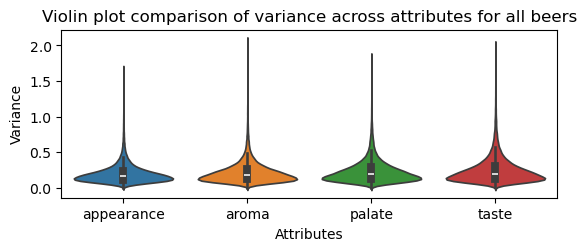

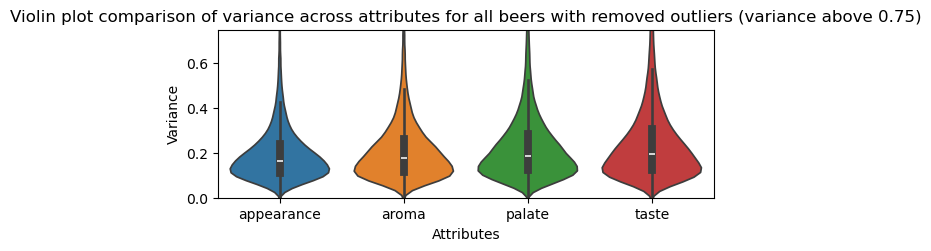

In [33]:
plt.subplot(2, 1, 1)
sns.violinplot(variance_ratings_attributes_BA[attributes])
plt.title("Violin plot comparison of variance across attributes for all beers")
plt.xlabel("Attributes")
plt.ylabel("Variance")
plt.show()

# Same graph with limited variance
plt.subplot(2, 1, 2)
sns.violinplot(variance_ratings_attributes_BA[attributes])
plt.title("Violin plot comparison of variance across attributes for all beers with removed outliers (variance above 0.75)")
plt.xlabel("Attributes")
plt.ylabel("Variance")
plt.ylim([0, 0.75])
plt.show()

As we can see, we have many outliers, making the distribution hard to read. Trying to remove high values, the graph still does not provide many information. Let's try to use a boxplot

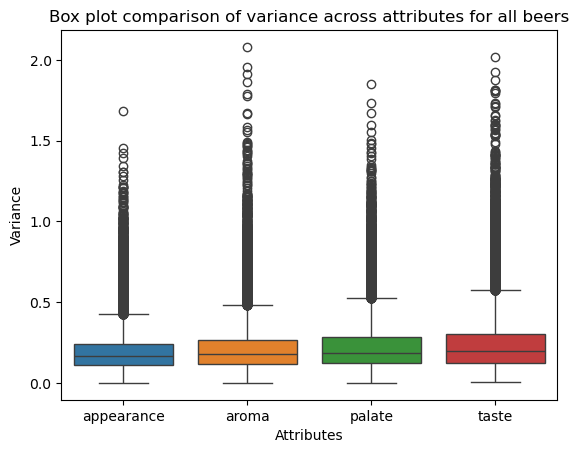

In [34]:
sns.boxplot(variance_ratings_attributes_BA[attributes])
plt.title("Box plot comparison of variance across attributes for all beers")
plt.xlabel('Attributes')
plt.ylabel('Variance')
plt.show()

Again, the graph is dominated by the really high number of data close to the mean. But as we have many many "outliers", it is really hard to draw any information concerning controversiality of attributes here

Let's finally try to plot the distributions

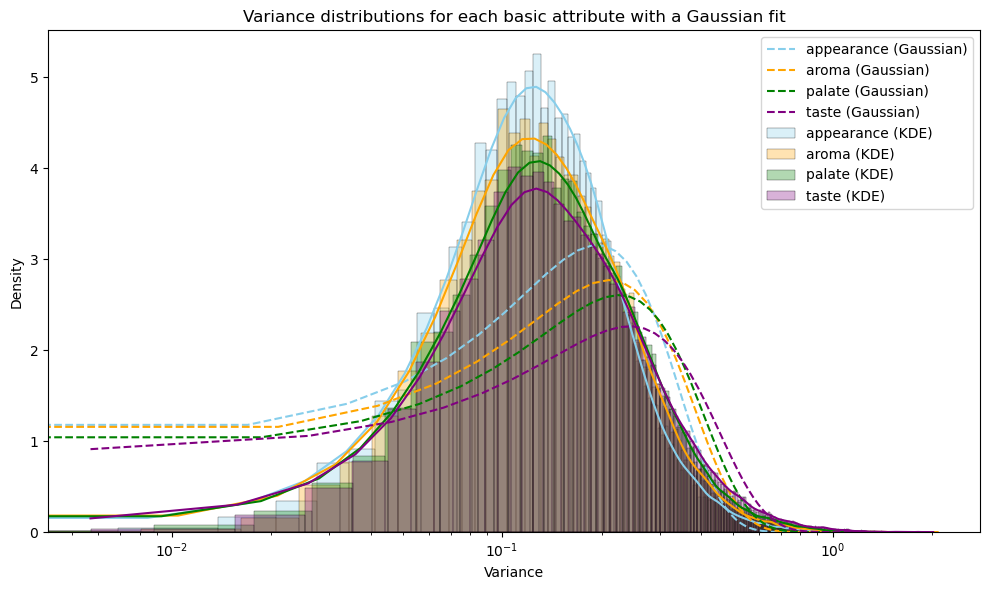

In [35]:
from scipy.stats import norm

plt.figure(figsize=(10, 6))
colors = ['skyblue', 'orange', 'green', 'purple']
for i, attribute in enumerate(attributes):
    #plt.hist(variance_ratings_attributes_BA[attribute], bins=10, log=(True, False))
    sns.histplot(variance_ratings_attributes_BA[attribute], kde=True, stat='density', color=colors[i], alpha=0.3, label=f"{attribute} (KDE)")

    mean = variance_ratings_attributes_BA[attribute].mean()
    std = variance_ratings_attributes_BA[attribute].std()
    
    # Generate x values for the Gaussian curve
    x = np.linspace(variance_ratings_attributes_BA[attribute].min(), 
                    variance_ratings_attributes_BA[attribute].max(), 100)
    
    # Plot the Gaussian curve as a dashed line
    plt.plot(x, norm.pdf(x, mean, std), color=colors[i], linestyle="--", label=f"{attribute} (Gaussian)")

plt.title('Variance distributions for each basic attribute with a Gaussian fit')
plt.xlabel("Variance")
plt.xscale("log")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()


Maybe we could do something like a big Gaussian with every variance. Then we find the value that are one std dev away from the mean and we select upper value to be controversial and lower value to be universal ????

The thing is for now we are looking for ALL beers with enough ratings what is the variance across the 4 different basic attributes.
We could :
- Look and groupby the type and abv of the beer. 
- "Group" the attributes and see if the beer is controversial
- Keep looking at WHAT makes it controversial


The 4 attributes are RATED by the user. While the abv and type of the beer are proper to the beer itself. We can either find which beers are controversial (style) or what makes it controversial......................

## Part 2.2
Let's try the analysis differently now :
- We compute the variance across the **overall** rating and classify beers as controversial if above a certain threshold. Then we look which of the 4 attributes influences the most the overall score controversiality

For this, we can either :
- Classify a beer as controversial/universal if above/below a certain threshold
- Classify a beer as controversial/universal if it is upper/lower than a quantile of the data


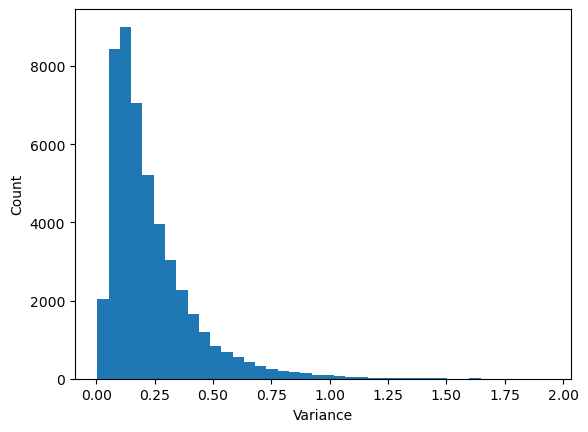

In [36]:
# Plot the distribution of variance across the beers for overall attributes
variance_ratings_overall_BA = grouped_ratings_BA.overall.var()

plt.hist(variance_ratings_overall_BA, bins = 40)
plt.xlabel("Variance")
plt.ylabel("Count")
plt.show()

In [ ]:
variance_ratings_overall_BA

### Part 2.2.1
Classify a beer as controversial/universal if above/below a certain threshold. Let's arbitrarily choose this threshold

In [ ]:
threshold_controversial_overall = 0.5
threshold_universal_overall = 0.1

# Extract beer id with controversial and universal overall score
controv_rating_id_BA = variance_ratings_overall_BA[variance_ratings_overall_BA.values >= threshold_controversial_overall]
univ_rating_id_BA = variance_ratings_overall_BA[variance_ratings_overall_BA.values <= threshold_universal_overall]

print("Percentage of beers with controversial overall score : {:.2f} %".format(100 * len(controv_rating_id_BA) / len(variance_ratings_overall_BA)))
print("Percentage of beers with universal overall score : {:.2f} %".format(100 * len(univ_rating_id_BA) / len(variance_ratings_overall_BA)))
# COULD GET A VARIABLE OF NB OF VALID BEERS INSTEAD OF LEN(VARIANCE_RATINGS_OVERALL)

# Actually, this could be similar to selecting an upper and lower percentage of the beers

0.7080229525299948
Percentage of beers with controversial overall score : 8.03 %
Percentage of beers with universal overall score : 21.17 %


We now extract the ratings of the beers with controversial and universal overall rating

In [ ]:
# Keep all ratings for which the beer is defined as controversial or universal
controv_ratings_BA = filtered_ratings_BA[filtered_ratings_BA['beer_id'].isin(controv_rating_id_BA.index)]
univ_ratings_BA = filtered_ratings_BA[filtered_ratings_BA['beer_id'].isin(univ_rating_id_BA.index)]

# Grouping again the remaining ratings per beer id and computing the variance of each attribute across each beer
var_ratings_controv_attr_BA = controv_ratings_BA.groupby('beer_id')[attributes].var()
var_ratings_univ_attr_BA = univ_ratings_BA.groupby('beer_id')[attributes].var()

In [53]:
var_ratings_controv_attr_BA.describe()

,appearance,aroma,palate,taste
count,3849.000000,3849.000000,3849.000000,3849.000000
mean,0.401194,0.495398,0.534728,0.639673
std,0.206591,0.225738,0.217767,0.238255
min,0.000000,0.037500,0.054545,0.058333
25%,0.254545,0.346117,0.384343,0.479532
50%,0.364881,0.454545,0.499594,0.598223
75%,0.507574,0.604971,0.655556,0.756183
max,1.682359,2.080556,1.852853,2.017173


This starts to be interesting.

From this, we learn that the beers with the most controversial overall score have a "significantly" higher variance across the taste, then palate and aroma and finally a "significantly" lower variance across the appearance. We can interpret this as if a beer has controversial opinions, this mostly comes from the taste attribute and less from appearance of the beer.

In [54]:
var_ratings_univ_attr_BA.describe()

,appearance,aroma,palate,taste
count,10144.000000,10144.000000,10144.000000,10144.000000
mean,0.103376,0.096224,0.098852,0.092633
std,0.055463,0.046668,0.048160,0.035905
min,0.006250,0.006250,0.005208,0.008814
25%,0.070139,0.068155,0.068910,0.068914
50%,0.094444,0.089583,0.093266,0.090625
75%,0.123106,0.113464,0.117647,0.111328
max,1.004545,0.732481,0.794444,0.562500


From this, we learn that the beers with the most universal overall score have quite similar variance across each attributes. However, we can still observe that, inversely to controversial beers, appearance has the highest variance mean and taste the smallest. This can enforce the fact that taste seems to be the attribute making a beer controversial OR universal, meaning it is the strongest attribute defining a beer. If taste and appearance variances are high and low respectively --> overall score variance has more odds of being high, if taste and appearance variances are low and high respectively --> overall score has more odds of being low.

IMPORTANT : COULD WE TRY TO HAVE A GRAPH SHOWING THAT THE HIGHER THE OVERALL VARIANCE, THE HIGHER THE TASTE VARIANCE THE LOWER THE APPEARANCE VARIANCE. THE LOWER THE OVERALL VARIANCE, THE LOWER THE TASTE VARIANCE THE HIGHER THE APPEARANCE. would be really cool to have such a graph proving this "correlation"

Try to show correlation between those things, maybe by applying kind of weight :
The higher the variance of the overall rating, the more the variance of other attributes on that beer counts.
The lower the variance of the overall rating, the more the SMALL variance of other attributes on that beer counts.
Maybe also add king of weight on the number of ratings ? Like 10 ratings is interesting but might be really low

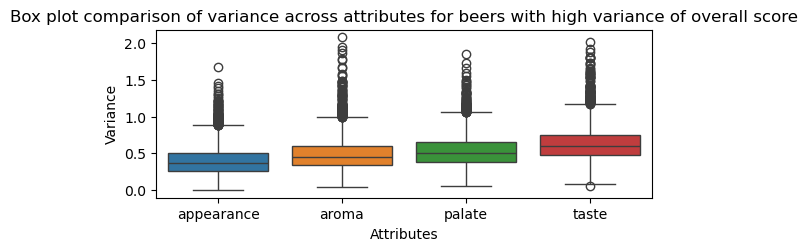

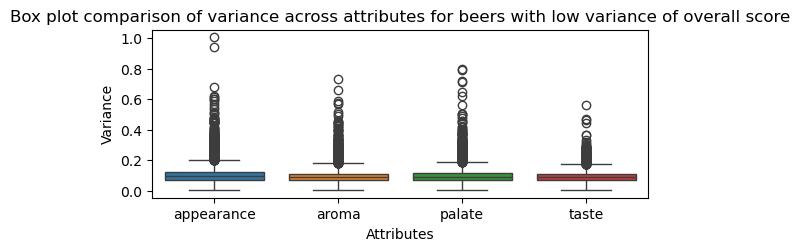

In [56]:
# Displaying box plot of the variance across the main attributes for beers with high or low variance of overall score
plt.subplot(2, 1, 2)
sns.boxplot(var_ratings_controv_attr_BA[attributes])
plt.title("Box plot comparison of variance across attributes for beers with high variance of overall score")
plt.xlabel('Attributes')
plt.ylabel('Variance')
plt.show()

plt.subplot(2, 1, 1)
sns.boxplot(var_ratings_univ_attr_BA[attributes])
plt.title("Box plot comparison of variance across attributes for beers with low variance of overall score")
plt.xlabel('Attributes')
plt.ylabel('Variance')
plt.show()

### Part 2.2.2
Classify a beer as controversial/universal if it is upper/lower than a quantile of the data
We now try this method to confirm our latest assumptions.

Let's pick a threshold percentage of beers with highest and lowest variance of overall rating. Let's say 10%

In [ ]:
threshold_percentage = 0.1 # 10 percent

# Finding the value of the quantile 10 % and 90%
top_threshold = variance_ratings_overall_BA.quantile(1-threshold_percentage)
bottom_threshold = variance_ratings_overall_BA.quantile(threshold_percentage)

# Filter for beer IDs in the top 10% or bottom 10%
controv_rating_id_BA = variance_ratings_overall_BA[variance_ratings_overall_BA.values >= top_threshold]
univ_rating_id_BA = variance_ratings_overall_BA[variance_ratings_overall_BA.values <= bottom_threshold]

# Asserting we have the right number of data
print("Percentage of beers with most controversial overall score : {:.2f} %".format(100 * len(controv_rating_id_BA) / len(variance_ratings_overall_BA)))
print("Percentage of beers with most universal (least controversial) overall score : {:.2f} %".format(100 * len(univ_rating_id_BA) / len(variance_ratings_overall_BA)))


Percentage of beers with most controversial overall score : 10.00 %
Percentage of beers with most universal (least controversial) overall score : 10.00 %


In [65]:
# Keep all ratings for which the beer is defined as controversial or universal
controv_ratings_BA = filtered_ratings_BA[filtered_ratings_BA['beer_id'].isin(controv_rating_id_BA.index)]
univ_ratings_BA = filtered_ratings_BA[filtered_ratings_BA['beer_id'].isin(univ_rating_id_BA.index)]

# Grouping again the remaining ratings per beer id and computing the variance of each attribute across each beer
var_ratings_controv_attr_BA = controv_ratings_BA.groupby('beer_id')[attributes].var()
var_ratings_univ_attr_BA = univ_ratings_BA.groupby('beer_id')[attributes].var()

In [66]:
var_ratings_controv_attr_BA.describe()

,appearance,aroma,palate,taste
count,4793.000000,4793.000000,4793.000000,4793.000000
mean,0.383793,0.468844,0.507460,0.603875
std,0.198345,0.216811,0.211692,0.232029
min,0.000000,0.035227,0.051136,0.058333
25%,0.244523,0.326316,0.365231,0.447656
50%,0.345421,0.429654,0.472619,0.559255
75%,0.481838,0.566667,0.622727,0.713158
max,1.682359,2.080556,1.852853,2.017173


As previously seen for the controversial defined beers, the mean variance for the taste attribute is the highest, followed by the palate, aroma and appearance.

In [68]:
var_ratings_univ_attr_BA.describe()

,appearance,aroma,palate,taste
count,4793.000000,4793.000000,4793.000000,4793.000000
mean,0.091235,0.081566,0.082759,0.074168
std,0.054960,0.043592,0.046803,0.031476
min,0.006250,0.006250,0.005208,0.008814
25%,0.058333,0.055556,0.056046,0.054945
50%,0.080556,0.073958,0.074658,0.070652
75%,0.109730,0.096980,0.099022,0.087500
max,0.944444,0.732481,0.794444,0.562500


Similarly, we also find that appearance has the highest variance when a beer is labeled as universal and taste the lowest.

Actually, part 2.2.1 is equivalent to classify all beers above or below a certain threshold. This results in the top x and y % of controversial and universal beers. Part 2.2.2 directly classify all beers in top and bottom x % quartile. As a result, both are similar but defining the threshold yourself, one has more liberty.

All results seems to go in the same direction. It indicates that when there is strong disagreement on a beer, much of this disagreement might stem from how people perceive its taste. When a beer is labeled as controversial regarding its overall variance, it seems to be due to the taste attribute. When a beer is labeled as universal it seems to be due to the taste too. As a result, it seems that taste variance is postively correlated with overall variance, while appearance variance is negatively correlated with overall variance.

However, this might also tell us that overall score is mostly influenced by taste attribute. As a result, if we just look at the variance of the overall beer to classify the beer as controversial or universal, of course we find the correlation with the versatility in the ratings of the taste and appearance. WE SHOULD TRY TO DO THIS AGAIN, SIMILARLY, LOOKING AT SENTIMATAL ANALYSIS. NEXT STEP FOR ME : CLASSIFY A BEER AS CONTROVERSIAL OR UNIVERSAL BASED ON GRADES OF REVIEWS (SENTIMENTAL ANALYSIS), THEN LOOK AT THE ATTRIBUTES VARIANCES !!! would be the same but don't use overall score to classify but sentimental analysis GRADE. Then, just try to find which attributes is the most responsible of controversiality or not. TO GO EVEN FURTHER, we can try to "train" or just get the sentiment analysis to indicate a grade for each of the attributes (in positive or negative ex if "good taste" in the comment, high grade for the taste, if "disgusting colour" low grade for appearance), then try again to find which attributes is the most controversial in the review by looking at this grade +/ornot ratings.

# 2.3
Let's now try to clarify wheter "taste" is the most controversial attribute, examining the correlation of the attributes with the overall attribute.

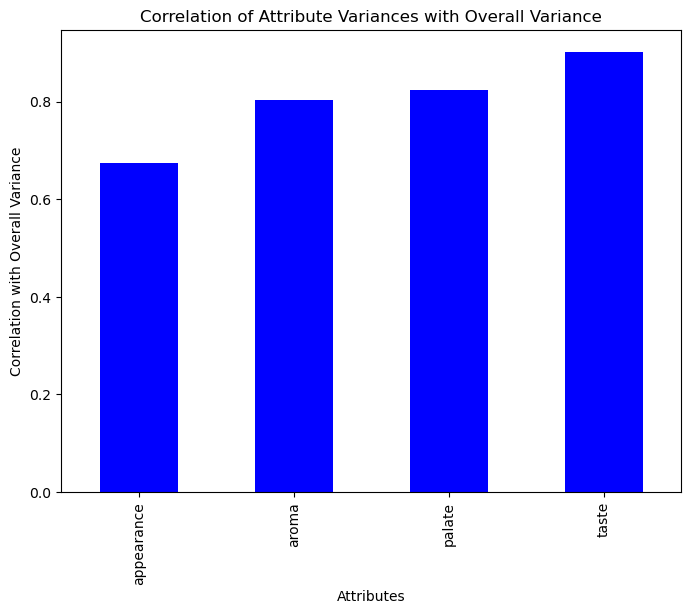

In [69]:
# Compute the variance of each attribute for each selected beers
variance_attributes_BA = grouped_ratings_BA[['overall', 'aroma', 'palate', 'taste', 'appearance']].var()

# Calculate the correlations between attributes variances and overall variance
correlations = variance_attributes_BA.corr()['overall'][attributes]

# Plot the correlation
plt.figure(figsize=(8, 6))
correlations.plot(kind='bar', color=['blue' if c > 0 else 'red' for c in correlations])
plt.title('Correlation of Attribute Variances with Overall Variance')
plt.xlabel('Attributes')
plt.ylabel('Correlation with Overall Variance')
plt.axhline(0, color='black', linewidth=0.5)
plt.show()


PAS ASSEZ CONVAINCU DU PLOT ICI :/